**Library Import**

In [11]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms

**Mount Drive**

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Path to Task1 Dataset ( Colorectal Cancer )**

In [3]:
colorectral_dataset_path = "/content/drive/MyDrive/Comp6321 project dataset/Colorectal Cancer"

**Create Torchvision Imagefolder dataset**

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as needed
    transforms.ToTensor(),
])

colorectral_dataset = ImageFolder(root=colorectral_dataset_path, transform=transform)

**Train, test, validation splitting**

In [5]:
# 70% Training, 15% Validation, 15% Testing
train_size = int(0.7 * len(colorectral_dataset))
val_size = int(0.15 * len(colorectral_dataset))
test_size = len(colorectral_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(colorectral_dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)


# Now you can create your dataloaders dictionary
colorectral_dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

# And your dataset_sizes dictionary
colorectral_dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

**Defining the Colorectral Cancer Detection Class**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
import copy

class ImageClassifier:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def create_model(self):
        # Create a ResNet model without pretraining
        model = models.resnet50(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, self.num_classes)
        return model.to(self.device)

    def get_loss(self):
        # Define the criterion
        return nn.CrossEntropyLoss()

    def get_optimizer(self, model):
        # Observe that all parameters are being optimized
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    def get_scheduler(self, optimizer):
        # Decay LR by a factor of 0.1 every 7 epochs
        return lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    def train_model(self, model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10):
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

         # to keep track of loss and accuracy for plotting
        train_loss, val_loss = [], []
        train_acc, val_acc = [], []

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_acc = epoch_acc.item()

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # record loss and accuracy
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, train_loss, val_loss, train_acc, val_acc

    def run(self, dataloaders, dataset_sizes):
        model = self.create_model()
        criterion = self.get_loss()
        optimizer = self.get_optimizer(model)
        scheduler = self.get_scheduler(optimizer)
        best_model = self.train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes)
        return best_model


**Training a ResNet-50 from scratch - Three Classes**

In [19]:
num_classes = 3
classifier = ImageClassifier(num_classes=num_classes)
colorectral_best_model, train_loss, val_loss, train_acc, val_acc = classifier.run(colorectral_dataloaders, colorectral_dataset_sizes)

Epoch 1/10
----------
train Loss: 0.9809 Acc: 0.5462
val Loss: 0.9446 Acc: 0.6611

Epoch 2/10
----------
train Loss: 0.6469 Acc: 0.7326
val Loss: 0.5600 Acc: 0.7867

Epoch 3/10
----------
train Loss: 0.5617 Acc: 0.7898
val Loss: 0.5719 Acc: 0.7711

Epoch 4/10
----------
train Loss: 0.5221 Acc: 0.8212
val Loss: 0.3348 Acc: 0.8833

Epoch 5/10
----------
train Loss: 0.3895 Acc: 0.8526
val Loss: 0.4522 Acc: 0.8089

Epoch 6/10
----------
train Loss: 0.3672 Acc: 0.8550
val Loss: 0.4438 Acc: 0.8633

Epoch 7/10
----------
train Loss: 0.3000 Acc: 0.8898
val Loss: 0.2589 Acc: 0.9078

Epoch 8/10
----------
train Loss: 0.2079 Acc: 0.9157
val Loss: 0.1746 Acc: 0.9333

Epoch 9/10
----------
train Loss: 0.1891 Acc: 0.9338
val Loss: 0.1705 Acc: 0.9422

Epoch 10/10
----------
train Loss: 0.1643 Acc: 0.9393
val Loss: 0.1803 Acc: 0.9422

Training complete in 9m 50s
Best val Acc: 0.942222


**Plotting Loss and Accuracy**

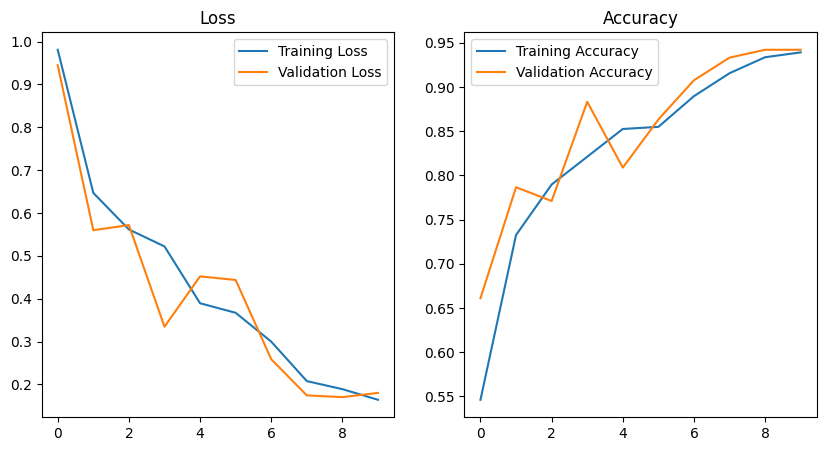

In [20]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.array(train_acc), label='Training Accuracy')
plt.plot(np.array(val_acc), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

**Save the best model**

In [21]:
torch.save(colorectral_best_model, colorectral_dataset_path + 'colorectral_model_weights.pth')